In [1]:
import numpy as np
from scipy import signal
from astropy.stats import sigma_clip
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import lightkurve as lk 
import pandas as pd

/Users/neisner/opt/anaconda3/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/neisner/.lightkurve/cache. Please move all the files in the legacy directory /Users/neisner/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
df_tess = pd.read_hdf("./data/tess_data_TOI197.h5")
#df_tess = pd.read_hdf("./data/tess_data_TIC48450369.h5")

# read in clean data 

time = np.array(df_tess.time.values)
flux = np.array(df_tess.flux.values)

good = np.logical_and(np.isfinite(time), np.isfinite(flux))

time = time[good] - np.median(time[good])
flux = flux[good] - np.median(flux[good])


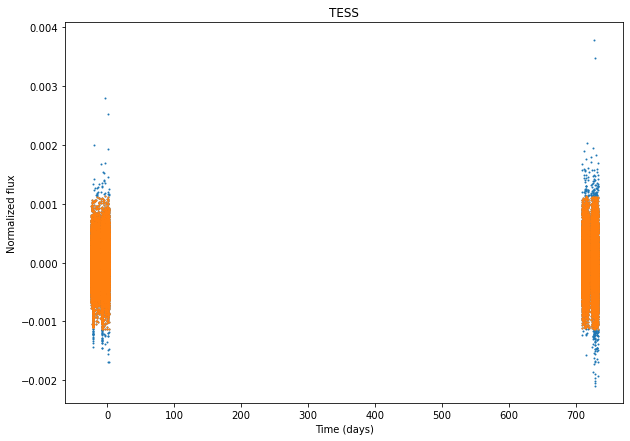

In [3]:
# plot data 

fig, ax = plt.subplots(figsize = (10,7))

plt.scatter(time, flux, s = 1, label = 'orig')



flux_sigclip = sigma_clip(flux, sigma=3, axis=0)


plt.scatter(time, flux_sigclip, s = 1, label = 'sig clipped')


plt.title("TESS")
plt.xlabel("Time (days)")
plt.ylabel("Normalized flux")
plt.show()

In [4]:
N = 10
Wn = 15 # critical frequency
fs = 720 # sampling frequency

sos = signal.butter(N, Wn, 'hp', fs=1000, output='sos')

filtered = signal.sosfilt(sos, flux)
filtered_sig_clip = signal.sosfilt(sos, flux_sigclip)


<IPython.core.display.Javascript object>


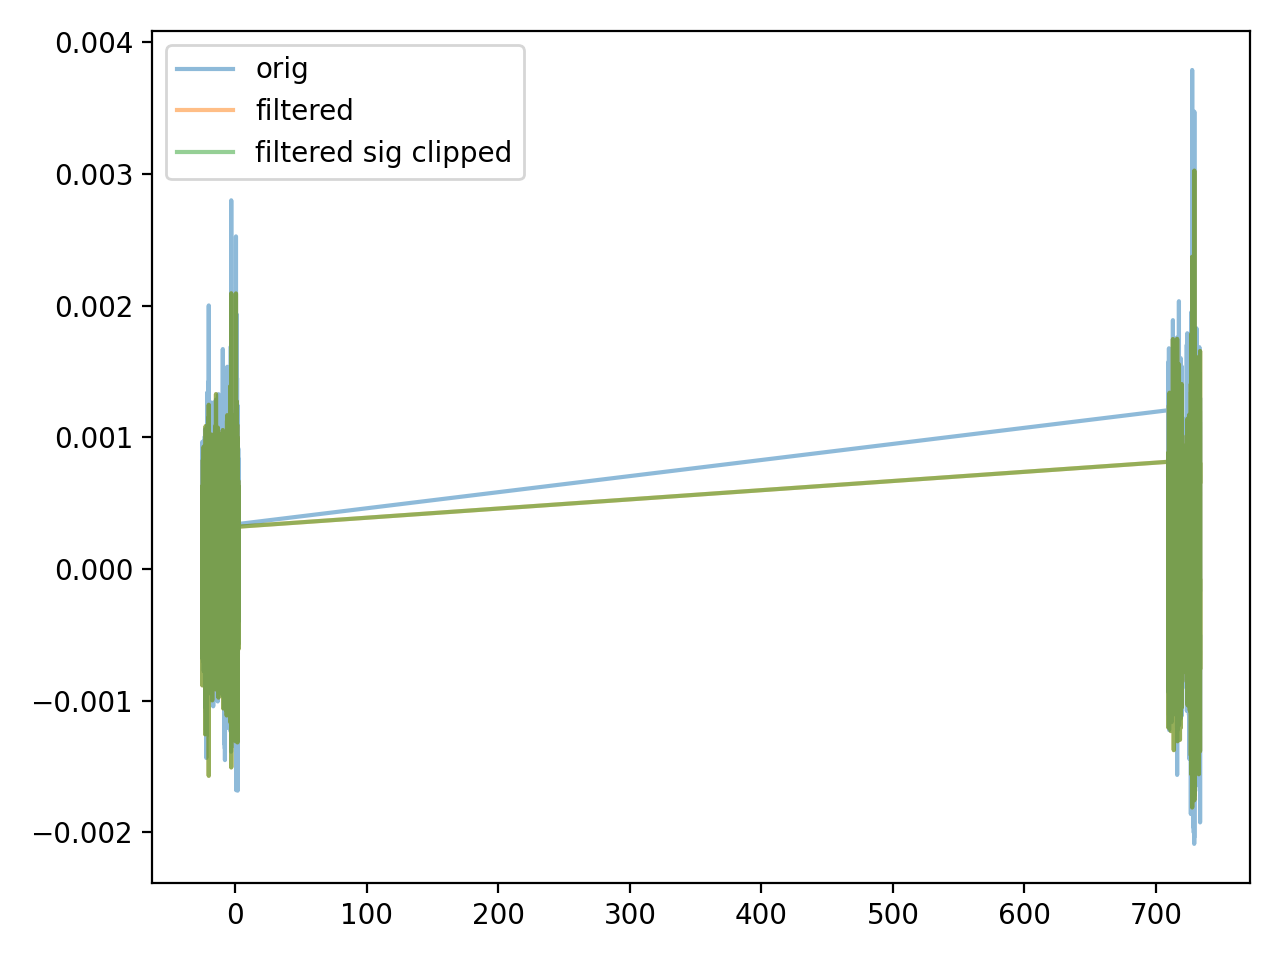

In [5]:
%matplotlib notebook

fig, ax = plt.subplots()

plt.plot(time, flux , label = 'orig', alpha = 0.5)
plt.plot(time, filtered, label = 'filtered', alpha = 0.5)
plt.plot(time, filtered_sig_clip , label = 'filtered sig clipped', alpha = 0.5)

plt.tight_layout()
plt.legend()
plt.show()

In [6]:
deltaf = 0.5/(np.max(time) - np.min(time))
maxf = 0.5 / np.median(time[1:] - time[:-1]) # assumes data are ordered in time
fgrid = np.arange(deltaf, maxf, deltaf)

pgrid = LombScargle(time, flux).power(fgrid)
pgrid_hp = LombScargle(time, filtered).power(fgrid)
pgrid_hp_sc = LombScargle(time, filtered_sig_clip).power(fgrid)


<IPython.core.display.Javascript object>


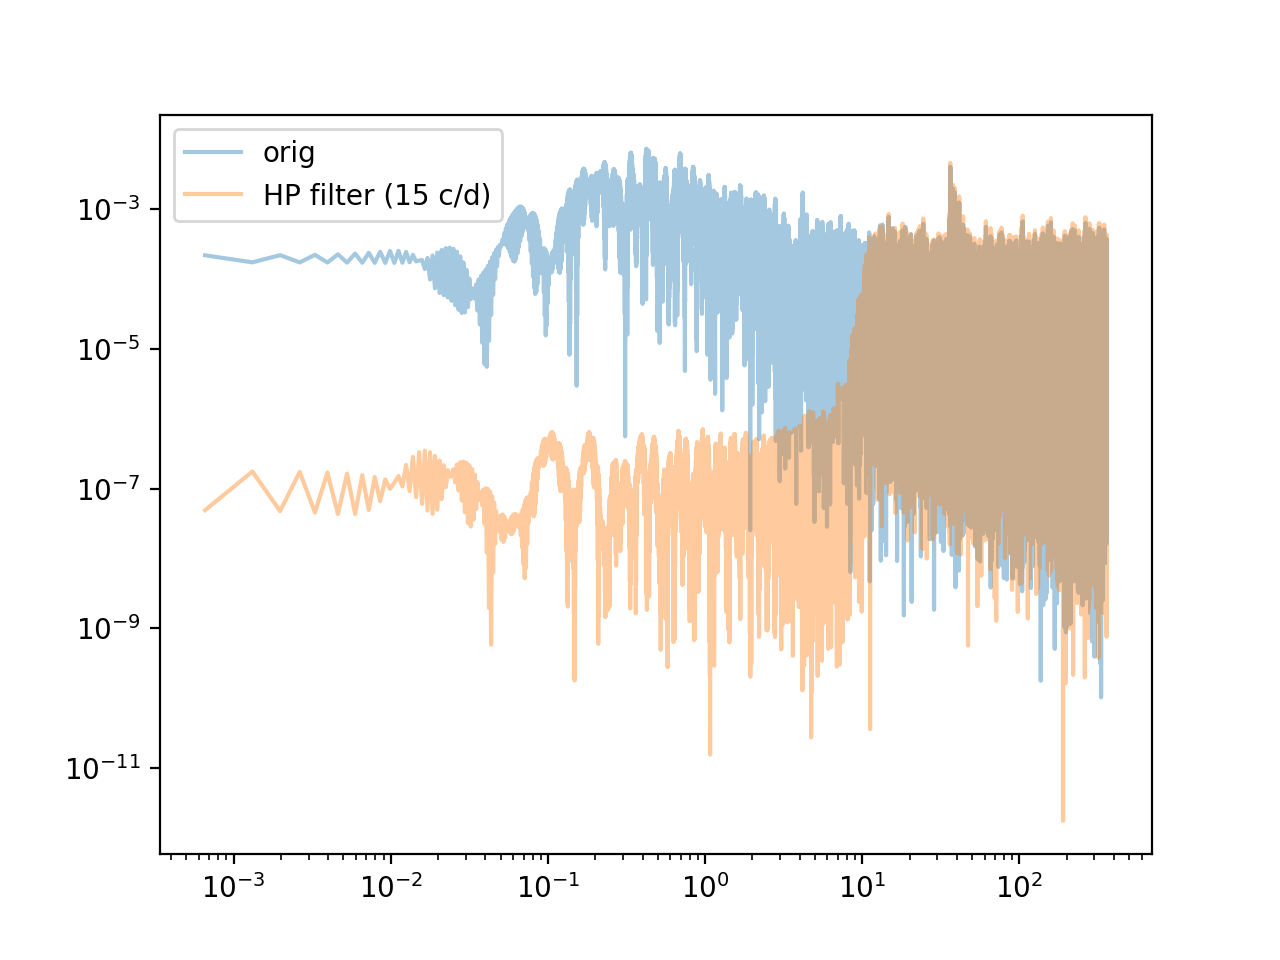

[]

In [7]:
fig, ax = plt.subplots()

plt.plot(fgrid, pgrid, label = 'orig', alpha = 0.4)
plt.plot(fgrid, pgrid_hp, label = 'HP filter (15 c/d)', alpha = 0.4)
#plt.plot(fgrid, pgrid_hp_sc, label = 'HP filter (15 c/d), 3 sigma clipped', alpha = 0.4)

plt.legend()
plt.loglog()

## 'perfect' data example

In [8]:
def sine(x, amplitude, frequency, phase):
    return amplitude*np.sin(2.*np.pi*frequency*x + phase)

In [9]:
times_gapped  = np.loadtxt('TIC55525572_yr3.txt').T
times = np.loadtxt('TIC55525572_yr3_nogaps.txt').T

amplitude = 2.
frequency = 1./0.02
phase = -0.4 * np.pi

flux_sine_       = sine(times, amplitude, frequency, phase)
flux_sine_gapped = sine(times_gapped,  amplitude, frequency, phase)


amp_gapped = LombScargle(times_gapped, flux_sine_gapped).power(fgrid)
amp_ = LombScargle(times, flux_sine_).power(fgrid)



In [10]:
# apply the high pass filter 

N = 10
Wn = 15 # critical frequency
fs = 720 # sampling frequency

sos = signal.butter(N, Wn, 'hp', fs=1000, output='sos')

flux_gapped_hpf = signal.sosfilt(sos, flux_sine_gapped)


In [11]:
deltaf = 0.5/(np.max(times_gapped) - np.min(times_gapped))
maxf = 0.5 / np.median(times_gapped[1:] - times_gapped[:-1]) # assumes data are ordered in time
fgrid = np.arange(deltaf, maxf, deltaf)

pgrid_gapped_hpf = LombScargle(times_gapped, flux_gapped_hpf).power(fgrid)
pgrid_gapped = LombScargle(times_gapped, flux_sine_gapped).power(fgrid)
pgrid_orig = LombScargle(times, flux_sine_).power(fgrid)


<IPython.core.display.Javascript object>


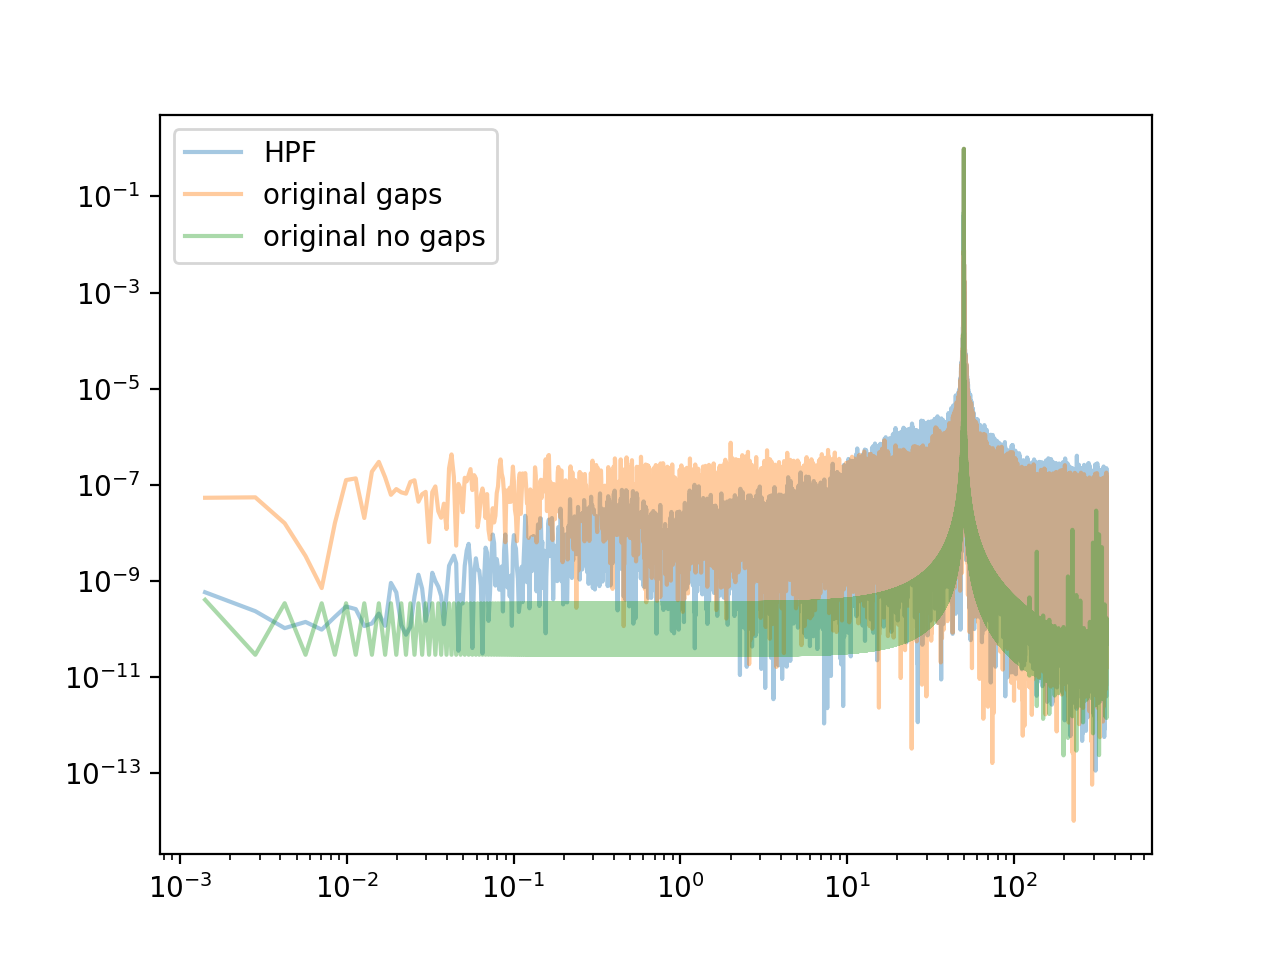

In [12]:
fig, ax = plt.subplots()

plt.plot(fgrid, pgrid_gapped_hpf, label = 'HPF', alpha = 0.4)
plt.plot(fgrid, pgrid_gapped, label = 'original gaps', alpha = 0.4)
plt.plot(fgrid, pgrid_orig, label = 'original no gaps', alpha = 0.4)

plt.legend()
plt.loglog()
plt.show()

<IPython.core.display.Javascript object>


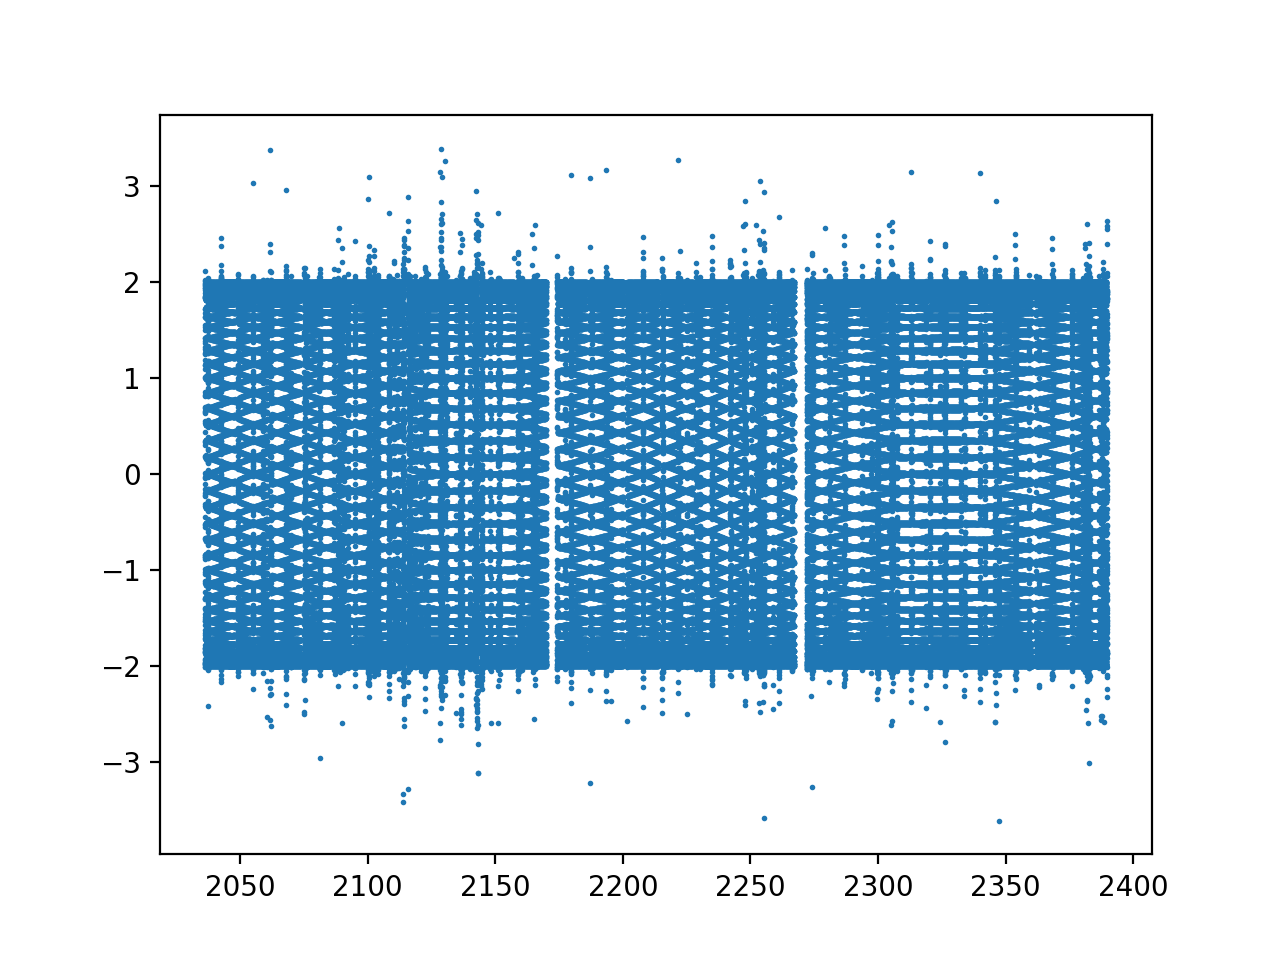

In [13]:
fig, ax = plt.subplots()

plt.scatter(times_gapped, flux_gapped_hpf, s = 1)